In [183]:
# IMPORTS


import pandas as pd
import chardet
import spacy
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer as tkn
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.models import load_model
from gensim.models import FastText
from nltk.tokenize import word_tokenize
import faiss
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from transformers import T5TokenizerFast, T5ForConditionalGeneration
import torch
import re
import pickle


In [184]:

# TEXT PREPROCESSING 


def find_text_column(columns):
    """Finds the best matching column based on keywords."""
    text_column_keywords = ['text', 'content', 'message', 'tweet', 'tweets', 'comment', 'comments' 'original', 'tweet_text', 'tweet_content', 'body', 'self_text']  # define keywords to identify the text column

    for keyword in text_column_keywords:
        for column in columns:
            if keyword.lower() == column.lower():
                return column
    
    return None

def preprocess_texts(texts, nlp, stop_words, stemmer):
    """Preprocesses a batch of texts."""
        
    docs = nlp.pipe(texts, disable=['ner', 'parser'])  # tokenisation and lemmatisation
    preprocessed_texts = []

    for doc in docs:
        tokens = []
        for token in doc:
            if token.is_alpha:  # check that token is alphabetic
                if not token.is_stop:  # exclude stop words
                    if token.text.lower() not in stop_words:  # check for stop words
                        stemmed_token = stemmer.stem(token.lemma_)  # apply stemming
                        tokens.append(stemmed_token)
                        if 'rt' in token.text.lower():
                            token.text.replace('rt', '')
        preprocessed_texts.append(" ".join(tokens))

    return preprocessed_texts


with open("data.pkl", "rb") as f:  # load the data file path from a pickle file
    filepath = pickle.load(f)
    
filepath = filepath.replace('"', '')
data_file = filepath  # get the data file from the user

try:
    with open(data_file, "rb") as f:  # open the file in binary mode to read the raw data
        raw_data = f.read()
except Exception as e:
    error = f"Error processing file: {e}"  # handle file reading errors
    with open("file_error.pkl", "wb") as f:
        pickle.dump(error,f)

detected_encoding = chardet.detect(raw_data)  # detect the file encoding
encoding = detected_encoding["encoding"]  # get the encoding from the detection result

try:
    df = pd.read_csv(data_file,
                     encoding=encoding,
                     on_bad_lines='skip',
                     delimiter=','
                     ) # read the CSV file into a DataFrame
            
    text_column = find_text_column(df.columns)  # find the text column
    open("file_error.pkl", "w").close()  # clear the file error file
    if text_column:
        print(f"Processing file using {text_column} column")  # alert user that text column was found
    else:
        print(f"Text column could not be identified")  # alert user that text column was not found
except Exception as e:
    print(f"Error reading the file: {e}")



chunk_size = 10000  # define chunk size to process at a time

stop_words = set(stopwords.words("english"))  # construct stopword list
stemmer = PorterStemmer()  # create stemmer object
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # load spaCy model

processed_df = pd.DataFrame()  # construct an empty DataFrame to store the processed data

for chunk in pd.read_csv(  # process each chunk
    data_file, encoding='utf-8',
    on_bad_lines='skip',
    delimiter=',',
    chunksize=chunk_size
):
    
    chunk = chunk[[text_column]]  # select only the text column
    chunk['Processed Text'] = preprocess_texts(chunk[text_column].astype(str), nlp, stop_words, stemmer)  # preprocess text and store in new column
    chunk.dropna(inplace=True)  # drop rows with missing values

    processed_df = pd.concat([processed_df, chunk], ignore_index=True)  # append processed chunk to dataframe variable

print(f"Processing complete. Processed {len(processed_df)} rows in total.")

with open("file_error.pkl", "wb") as f:
        pickle.dump("File Processing Successfully...",f)


Processing file using self_text column
Processing complete. Processed 500 rows in total.


In [ ]:
# SENTIMENT ANALYSIS AND CONTROVERSY CALCULATION


def get_token_info(data, tokeniser):
    """Gets the word index for a given dataset."""
    tokeniser.fit_on_texts(data)  # tokenise text
    index = tokeniser.word_index  # get word index
    
    return index

def optimal_length(data):
    """Calculates the optimal sequence length for a given dataset."""
    text_lengths = []
    text_lengths = data.apply(lambda x: len(x.split()))  # get length of each text 
    optimal_length = np.percentile(text_lengths, 90)  # optimal length covers 90 percent of the data
    
    return optimal_length

def calculate_controversy(labels):
    """Calculates the controversy of a given set of proportions."""

    pos_count = 0
    neu_count = 0
    neg_count = 0

    for label in labels:
      if label == 0:
          neg_count += 1
      elif label == 1:
          neu_count += 1
      elif label == 2:
          pos_count += 1
    total = (neg_count+neu_count+pos_count)  # total number of labels

    # proportions of each label
    p = pos_count/total
    n = neg_count/total
    u = neu_count/total

    c = (1 - abs(p - n)) * (1 - u)  # calculate the controversy

    return float("{:.2f}".format(c))

df = processed_df  # load processed data
df['Tokens']=df[df.columns[0]].apply(lambda x: word_tokenize(x))

tokeniser = tkn(num_words=10000, oov_token='<OOV>')  # construct tokeniser
word_index = get_token_info(df[df.columns[0]], tokeniser)  # index of words in corpus
max_length = int(optimal_length(df[df.columns[0]]))  # get optimal sequence length

x_sequences = tokeniser.texts_to_sequences(df[df.columns[0]])  # convert text to sequences
x_padded = pad_sequences(x_sequences, maxlen=max_length, padding='post', truncating='post')  # pad sequences

model = load_model(r"001215283-FYP_Code\SAControversyV2_Model.keras")  # load model

with tf.device('/GPU:0'):  # use GPU for predictions
    predictions = model.predict(x_padded)  # predict sentiment

predictions = np.argmax(predictions, axis=1)  # get predicted labels
unique, counts = np.unique(predictions, return_counts=True)

sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [sentiment_labels[pred] for pred in predictions]  # convert encoded labels to readable labels
df['Predicted Sentiment'] = predicted_labels

with open("cs.pkl", "wb") as f:
    pickle.dump(calculate_controversy(predictions), f)  # save controversy score
print(f"Controversy Score: {calculate_controversy(predictions)}")  # calculate controversy of predictions

with open("cd.pkl", "wb") as f:
    pickle.dump(dict(zip(unique+1, counts)), f)  # save cluster distribution
print(f"Sentiment Distribution: {dict(zip(unique+1, counts))}")  # print predicted label counts

16/16 [==============================] - 1s 39ms/step
Controversy Score: 0.36
Sentiment Distribution: {1: 147, 2: 285, 3: 68}


In [186]:
# VECTORISATION FOR CLUSTERING


def vectorise(sentence, model, embedding_dim=300):
    """Generates an vector for a sentence using a word embedding model."""
    valid_words = [word for word in sentence if word in model]
    if valid_words:
        return np.mean([model[word] for word in valid_words], axis=0)  # average the embeddings of valid words
    else:
        return np.zeros(embedding_dim)  # if empty return zero vector


tokenised_sentences = df[df.columns[0]].astype(str).apply(lambda x: word_tokenize(x))  # tokenise sentences

ft_model = FastText(  # generate embeddings 
    sentences=tokenised_sentences, 
    vector_size=300,               
    window=5,  # context window size
    min_count=2,  # minimum word frequency to be considered
    workers=8,  # number of threads                     
    sg=1)  #skip-gram model

embedding_dim = ft_model.vector_size  # get embedding dimension
X = np.array([vectorise(sentence, ft_model.wv) for sentence in tokenised_sentences])  # generate embeddings


In [187]:
# FAISS CLUSTERING


scaler = StandardScaler()  # standardisation object
X = scaler.fit_transform(X)  # standardise vectors before clustering

num_clusters = 3  # number of clusters

kmeans = faiss.Kmeans(d=embedding_dim, k=num_clusters, niter=100, verbose=True, gpu=True)  # construct k-means object
kmeans.train(X)  # train k-means model

_, labels = kmeans.index.search(X, 1)  # get cluster labels
labels = labels.flatten()  # flatten labels
unique, counts = np.unique(labels, return_counts=True)

df['Cluster'] = labels  # assign cluster labels to DataFrame rows

ch_score = calinski_harabasz_score(X, labels)  # calculate Calinski-Harabasz score


Clustering Calinski Harabasz Score: 204.37508400049697


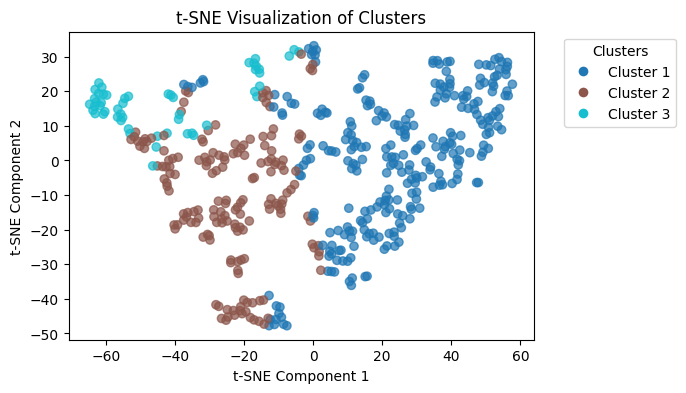

In [188]:
# DISPLAY AND PLOT RESULTS


pd.set_option('display.max_rows', None)  # display all rows
pd.set_option('display.max_colwidth', None)  # display full text

print(f"Clustering Calinski Harabasz Score: {ch_score}")  # print Calinski-Harabasz score

if X.shape[0] <= 1000:
    perplexity = 10
elif 1000 < X.shape[0] <= 5000:
    perplexity = 20
elif 5000 < X.shape[0] <= 10000:
    perplexity = 30
elif 10000 < X.shape[0] <= 50000:
    perplexity = 40
else:
    perplexity = 50

pca = PCA(n_components=50, random_state=42)  # construct PCA object
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)  # construct t-SNE object

pca_reduced = pca.fit_transform(X)  # reduce dimensions for further reduction by t-sne
reduced_vectors = tsne.fit_transform(pca_reduced)  # reduce dimensions for plotting on 2D graph

fig, ax = plt.subplots(figsize=(6, 4))  # save figure and axis objects
scatter = ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1],   
                      c=labels, cmap='tab10', alpha=0.7)  # plot clusters

num_clusters = len(set(labels))   # get number of clusters
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(i), markersize=8) 
           for i in range(num_clusters)]  # create legend

ax.legend(handles, [f"Cluster {i+1}" for i in range(num_clusters)], title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')  # add legend
ax.set_title("t-SNE Visualization of Clusters")
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")

with open("fig.pkl", "wb") as f:
        pickle.dump(fig, f)  # save figure object



In [ ]:
# LEX RANK SENTENCE SELECTION


def select_sentences(text, num_sentences=10):
    """Chooses sentences that are mnost represenative of each cluster (extractive)"""
    
    parser = PlaintextParser.from_string(text, Tokenizer("english"))  # construct parser object
    summariser = LexRankSummarizer()  # construct the summariser object
    selection = summariser(parser.document, num_sentences)  # select sentences
    
    cluster_sentences = []  # list to contain selected sentences
    
    for sentence in selection:
        cluster_sentences.append(str(sentence).replace('.',''))
        
    return cluster_sentences  # return sentences as a list

def get_original_text(text):
    """Retrives the raw text form of the clean text provided"""
    original = df[df.columns[0]].values[df['Processed Text'] ==  text]
    return str(original)

def process_text(text):
    """Joins sentences, converts encoded tokens and removes URLs"""
    original_text = str('. '.join(text)).replace('[','').replace(']','').replace('"','').replace("'",'').replace(r'\n','')  # join sentences
    original_text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', original_text)  # remove URLs
    original_text = re.sub(r'#', '', original_text)  # turn hashtags into plain text
    original_text = re.sub(r'RT', '', original_text)  # remove retweet tags
    original_text = re.sub(r'GIF.+|gif.+', '', original_text)  # remove retweet tags    
    original_text = re.sub(r'&amp;', 'and', original_text)  # replace encoded ampersands
    original_text = re.sub(r'&gt;', 'greater than', original_text)  # replace encoded greater than signs
    original_text = re.sub(r'&lt;', 'less than', original_text)  # replace encoded less than signs
    original_text = re.sub(r'&quot;', '"', original_text)  # replace encoded quotes
    original_text = re.sub(r'&apos;', "'", original_text)  # replace encoded apostrophes
    original_text = re.sub(r'&', 'and', original_text)  # replace ampersands with 'and'
    original_text = re.sub(r'\n', '', original_text)  # remove newline characters
    original_text = re.sub(r'[\u2066\u2067\u2068\u2069]', '', original_text)  # remove special characters
    original_text = re.sub(r'\\x.+', '', original_text)  # remove encoding tags
    original_text = re.sub(r'Replying to', '', original_text)  # remove reply tags
    original_text = re.sub(r'\\', "'", original_text)  # remove backslashes
    original_text = re.sub(r'\.+', ".", original_text)  # make sure full stops don't duplicate
    original_text = re.sub(r'[^a-zA-Z.,!?;:"(){}[\]<>@#$%^&*-_/\\+=~\s]', '', original_text)  # remove non-standard characters



    return original_text

full_sentences = []  # will contain all sentences to be summarised

for cluster in range(num_clusters):  # for each cluster
    cluster_df = df[df['Cluster'] == cluster]  # select the texts in each cluster
    cluster_text = ". ".join(cluster_df[df.columns[1]].values)  # join them into one string
    selected_sentences = (select_sentences(cluster_text))  # select the most representative sentences using LexRank and add to list
    
    original_sentences = []  # will contain the raw text version of the sentences 
    
    for sentence in selected_sentences:
        original_sentences.append(get_original_text(sentence))  # get original unprocessed text

    processed_text = process_text(original_sentences)  # process text

    full_sentences.append(processed_text)  # add to list
    print(processed_text)
    print("--------------------------------------------------------")

greater thanThe climate changes regardless of human actions.This is called a strawman argument, no one is claiming that climate hasnt changed over time. Were talking about the adverse affect of burning billions of metric tons of fossil fuels every single year into the atmosphere.s important to remember that scientists always focus on the evidence, not on opinions. Scientific evidence continues to show that human activities (primarily the human burning of fossil fuels) have warmed Earths surface and its ocean basins, which in turn have continued to impact Earths climate. This is based on over a century of scientific evidence forming the structural backbone of todays civilization.s climate has changed throughout history. Just in the last 800,000 years, there have been eight cycles of ice ages and warmer periods, with the end of the last ice age about 11,700 years ago marking the beginning of the modern climate era  and of human civilization. Most of these climate changes are attributed t

In [ ]:
# SUMMARISE SELECTED SENTENCES


tokenizer = T5TokenizerFast.from_pretrained("google/flan-t5-large")  # construct model tokeniser
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")  # construct transformer object

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check for gpu availability and use if possible
model = model.to(device)  # ensure model is on the same device as the tensors

all_summaries = []  # will contain all summaries

for cluster in range(num_clusters):  # for each cluster
    prompt = f"Write a summary for these sentences: {full_sentences[cluster]}"  # prompt to feed to the transformer
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.to("cuda")  # prepare data for transformation
    input_ids = input_ids.to(device)  # ensure input tensor is on the same device as everything else
    
    with tf.device('/GPU:0'):  # use gpu
        outputs = model.generate(input_ids,  # generate summary
                                 max_length=100,  # maximum length of the summary
                                 min_length=10,  # minimum length of the summary
                                 length_penalty=0.8,  # keeps generated text at a reasonable length
                                 num_beams=2, # number of beams to use in beam search
                                 repetition_penalty=1.5) # penalises repetition of words while maintaining coherence
        
    summarised_text = (tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','').replace('<unk>',''))  # save summarised text to variable=
    all_summaries.append(summarised_text)  # add to list
      
    print(f'Cluster {cluster+1} Summary: {summarised_text}')  # print summary

with open("summaries.pkl", "wb") as f:
    pickle.dump(all_summaries, f)  # save summaries

Cluster 1 Summary:  Climate change is no joke, the biggest missing component in the education of students these days is that *we are working on very effective solutions*. And, perhaps even more encouraging, Earth has excellent natural mechanisms of repairing itself and restoring homeostasis. Now, we are currently pushing this
Cluster 2 Summary:  The author conveniently not including/dismissing the PBO report where 80% of Canadians are NOT benefiting from the carbon tax.
Cluster 3 Summary:  I'm a big fan of this show. It's like a little bit of a reality show, but it's also a lot of fun.


In [191]:
display(df.head())

,self_text,Processed Text,Tokens,Predicted Sentiment,Cluster
0,why dont you tell that to Encryption experts-- I'm sure they need a good laugh,not tell encrypt sure need good laugh,"[why, dont, you, tell, that, to, Encryption, experts, --, I, 'm, sure, they, need, a, good, laugh]",negative,0
1,Good. Now give Ukraine every weapon it needs to turn the Russians into wild animal feed. Immediately,good ukrain weapon need turn russian wild anim feed immedi,"[Good, ., Now, give, Ukraine, every, weapon, it, needs, to, turn, the, Russians, into, wild, animal, feed, ., Immediately]",neutral,0
2,Indoor Mini Golf!!!! Because the dang golf courses are flooded.,indoor mini golf dang golf cours flood,"[Indoor, Mini, Golf, !, !, !, !, Because, the, dang, golf, courses, are, flooded, .]",neutral,2
3,Israeli propaganda,isra propaganda,"[Israeli, propaganda]",neutral,2
4,1908 is when oil was first discovered in the region.\n\nAt that point these were all either Ottoman provinces or protectorates of European powers with the exception of Persia.\n\nSo… yeah… basically none of these nations existed.,oil discov region point ottoman provinc protector european power except persia yeah basic nation exist,"[1908, is, when, oil, was, first, discovered, in, the, region, ., At, that, point, these, were, all, either, Ottoman, provinces, or, protectorates, of, European, powers, with, the, exception, of, Persia, ., So…, yeah…, basically, none, of, these, nations, existed, .]",negative,1
